# Notebook 2 : Prétraitement des images de voitures

- Mapping entre les 32 classes (road, sidewalk, parking...) et les 8 groupes (human, vehicle...) que l'on veut classifier.

- Renommage des fichiers masque / image

- Sauvegarde dans un dossier "processed"


## Imports

In [1]:
import os
import cv2
import numpy as np
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt


## Configuration

In [2]:
DATA_DIR = "../data"
RAW_DIR = os.path.join(DATA_DIR, "raw")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")

## Redimensionnement de petite taille pour faciliter le traitement
## Taille d'origine : 1024 x 2048 (cf. notebook 1)
IMG_HEIGHT = 128
IMG_WIDTH = 256


NUM_CLASSES = 8


## Class Mapping

Source : https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

In [3]:
CLASS_MAPPING = {
    0: 0,    # 'unlabeled'            -> void
    1: 0,    # 'ego vehicle'          -> void
    2: 0,    # 'rectification border' -> void
    3: 0,    # 'out of roi'           -> void
    4: 0,    # 'static'               -> void
    5: 0,    # 'dynamic'              -> void
    6: 0,    # 'ground'               -> void
    7: 1,    # 'road'                 -> flat
    8: 1,    # 'sidewalk'             -> flat
    9: 1,    # 'parking'              -> flat
    10: 1,   # 'rail track'           -> flat
    11: 2,   # 'building'             -> construction
    12: 2,   # 'wall'                 -> construction
    13: 2,   # 'fence'                -> construction
    14: 2,   # 'guard rail'           -> construction
    15: 2,   # 'bridge'               -> construction
    16: 2,   # 'tunnel'               -> construction
    17: 3,    # 'pole'                 -> object
    18: 3,    # 'polegroup'            -> object
    19: 3,    # 'traffic light'        -> object
    20: 3,    # 'traffic sign'         -> object
    21: 4,   # 'vegetation'           -> nature
    22: 4,   # 'terrain'              -> nature
    23: 5,   # 'sky'                  -> sky
    24: 6,   # 'person'               -> human
    25: 6,   # 'rider'                -> human
    26: 7,   # 'car'                  -> vehicle
    27: 7,   # 'truck'                -> vehicle
    28: 7,   # 'bus'                  -> vehicle
    29: 7,   # 'caravan'              -> vehicle
    30: 7,   # 'trailer'              -> vehicle
    31: 7,   # 'train'                -> vehicle
    32: 7,   # 'motorcycle'           -> vehicle
    33: 7,   # 'bicycle'              -> vehicle
    -1: 7     # 'license plate'        -> vehicle
}


## Fonctions Utilitaires

In [4]:
def remap_classes(mask, mapping):
    remapped_mask = np.zeros_like(mask, dtype=np.uint8)
    for old_class, new_class in mapping.items():
        remapped_mask[mask == old_class] = new_class
    return remapped_mask

def get_city_name(image_path):
    return image_path.split('/')[-2]

def get_image_name(image_path):
    return image_path.split('/')[-1].split('_leftImg8bit')[0]


# Définition de la fonction de préparation des données

In [5]:
def prepare_data(image_dir, gt_dir, output_dir, class_mapping, img_height, img_width, dataset_type):
    """
    Prépare les données en : 
        1. remappant les classes des masques de segmentation
        2. en redimensionnant les images et les masques
        3. en les sauvegardant dans un nouveau répertoire.
    """
    print(f"Préparation des données pour le dataset : {dataset_type}")

    # Créer les répertoires de sortie s'ils n'existent pas
    os.makedirs(output_dir, exist_ok=True)

    # Définir les chemins des images et des masques en fonction du type de dataset
    image_dir = os.path.join(image_dir, dataset_type)
    gt_dir = os.path.join(gt_dir, dataset_type)
    output_dir = os.path.join(output_dir, dataset_type)

    # Parcourir les villes
    for city in tqdm(os.listdir(image_dir), desc="Processing Cities"):
        city_image_dir = os.path.join(image_dir, city)
        city_gt_dir = os.path.join(gt_dir, city)
        city_output_dir = os.path.join(output_dir, city)
        os.makedirs(city_output_dir, exist_ok=True)

        # Parcourir les images
        for image_file in os.listdir(city_image_dir):
            if image_file.endswith('.png'):
                image_name = get_image_name(image_file)
                image_path = os.path.join(city_image_dir, image_file)
                mask_path = os.path.join(city_gt_dir, f"{image_name}_gtFine_labelIds.png")

                output_image_path = os.path.join(city_output_dir, f"{image_name}_image.png")
                output_mask_path = os.path.join(city_output_dir, f"{image_name}_mask.png")

                # Charger l'image et le masque
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

                # Redimensionner l'image et le masque
                image = cv2.resize(image, (img_width, img_height))
                ## redimensionnement du masque : interpolation (nearest neighboor)
                mask = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

                # Remaaper les classes du masque
                remapped_mask = remap_classes(mask, class_mapping)

                # Sauvegarder l'image et le masque remappé
                cv2.imwrite(output_image_path, image)
                cv2.imwrite(output_mask_path, remapped_mask)

    print(f"Préparation des données terminée pour le dataset : {dataset_type}")


## Préparation des données

In [6]:
DATASET_TYPES = ['train', 'val', 'test']

for dataset_type in DATASET_TYPES:
    prepare_data(
        image_dir=os.path.join(RAW_DIR, "leftImg8bit"),
        gt_dir=os.path.join(RAW_DIR, "gtFine"),
        output_dir=PROCESSED_DIR,
        class_mapping=CLASS_MAPPING,
        img_height=IMG_HEIGHT,
        img_width=IMG_WIDTH,
        dataset_type=dataset_type
    )

print("Préparation des données terminée pour tous les datasets.")


Préparation des données pour le dataset : train


Processing Cities: 100%|████████████████████████| 18/18 [04:58<00:00, 16.56s/it]


Préparation des données terminée pour le dataset : train
Préparation des données pour le dataset : val


Processing Cities: 100%|██████████████████████████| 3/3 [00:45<00:00, 15.31s/it]


Préparation des données terminée pour le dataset : val
Préparation des données pour le dataset : test


Processing Cities: 100%|██████████████████████████| 6/6 [02:19<00:00, 23.18s/it]

Préparation des données terminée pour le dataset : test
Préparation des données terminée pour tous les datasets.


## Vérification

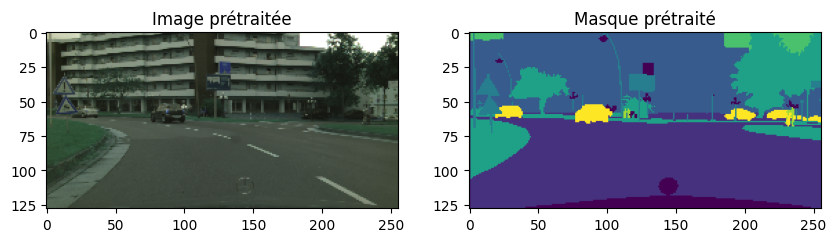

Valeurs uniques dans le masque : [0 1 2 3 4 5 6 7]


In [7]:
# Charger une image et un masque prétraités
image = cv2.imread("../data/processed/train/aachen/aachen_000000_000019_image.png")

mask = cv2.imread("../data/processed/train/aachen/aachen_000000_000019_mask.png", 
                  cv2.IMREAD_UNCHANGED)

# Afficher l'image et le masque
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Image prétraitée")
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Masque prétraité")
plt.show()

# Afficher les valeurs uniques dans le masque
print("Valeurs uniques dans le masque :", np.unique(mask))
